In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
predictions = model(x_train[:1]).numpy()
predictions

array([[0.07914133, 0.10299829, 0.28350648, 0.04904894, 0.10595463,
        0.08933631, 0.03464972, 0.07243898, 0.11429995, 0.06862532]],
      dtype=float32)

In [9]:
predictions.shape

(1, 10)

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train[:1], predictions).numpy()

2.3155005

In [11]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [12]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 7s 3ms/step - loss: 0.2979 - accuracy: 0.9123
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1461 - accuracy: 0.9568
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1092 - accuracy: 0.9670
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0887 - accuracy: 0.9725
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0745 - accuracy: 0.9771


In [16]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0730 - accuracy: 0.9768 - 571ms/epoch - 2ms/step


[0.07301615178585052, 0.9768000245094299]

In [17]:
path = "/content/drive/MyDrive/0-9"

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [19]:
# 데이터 불러오기
dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                      shuffle=True,
                                                        batch_size=10,
                                                        image_size=(160, 160))

Found 426 files belonging to 10 classes.


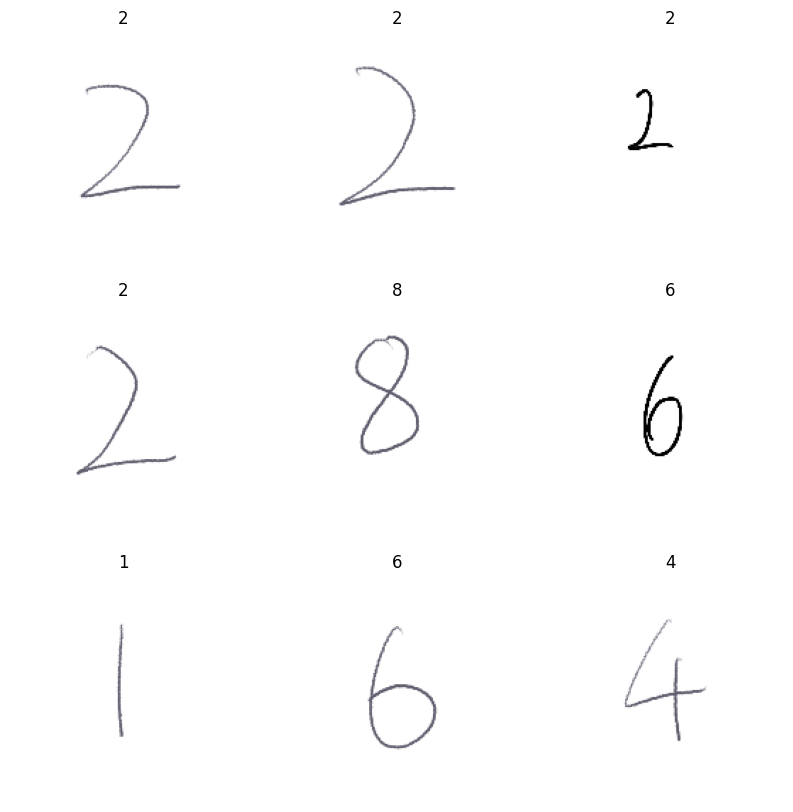

In [21]:
# 라벨 확인하기
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
# 배치 크기로 나누기
batches = tf.data.experimental.cardinality(dataset)
train_dataset = dataset.take(batches * 4 // 5)
test_dataset = dataset.skip(batches * 4 // 5)

print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(test_dataset))

tf.Tensor(34, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [23]:
# 버퍼링된 프리페치로 I/O 차단 없이 디스크에서 이미지 로드(성능향상)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

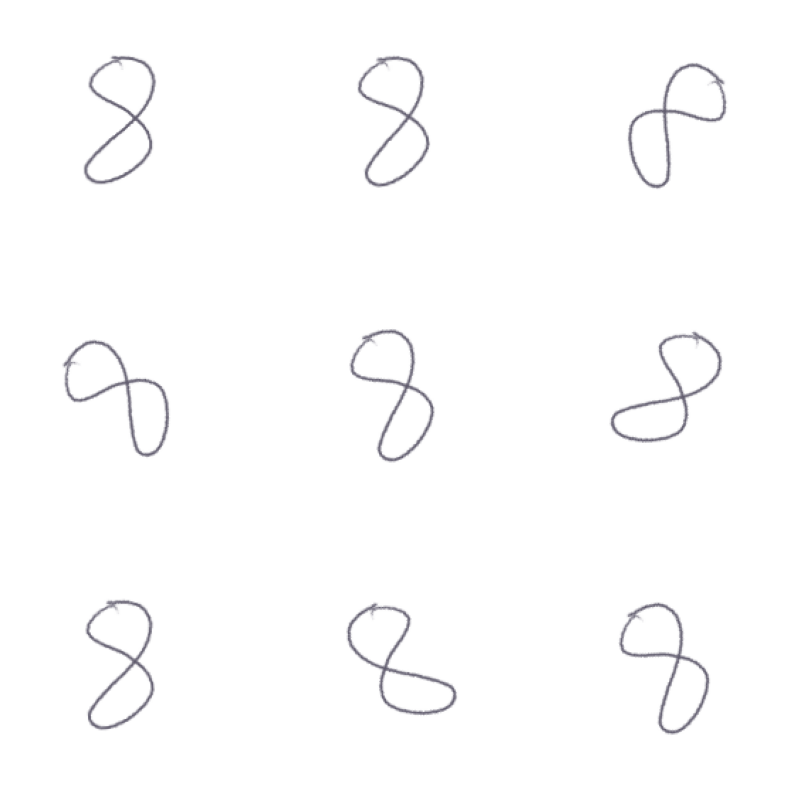

In [24]:
# 데이터 증강 사용
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [25]:
# 픽셀값 재조정 -1 ~ 1 의 값, 모델에 맞게 사용
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [26]:
# 전이학습의 기본 모델 설정
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (160, 160) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [28]:
# 베이스 모델로의 변환 확인
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 1280)


In [29]:
# 베이스 모델 학습 하지 않음
base_model.trainable = False

In [30]:
# 입력 이미지를 모델에 맞게 변환
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [32]:
# 모델의 출력부 확인
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 10)


In [33]:
# 모델 생성
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
# 모델 컴파일
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
# 모델의 학습 가능 매개변수 확인
len(model.trainable_variables)

2

In [36]:
initial_epochs = 10

In [37]:
# 10 학습 후 결과
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/10
34/34 [==============================] - 109s 3s/step - loss: 2.5707 - accuracy: 0.1088 - val_loss: 2.2198 - val_accuracy: 0.2674
Epoch 2/10
34/34 [==============================] - 9s 254ms/step - loss: 2.2548 - accuracy: 0.1706 - val_loss: 1.9938 - val_accuracy: 0.2674
Epoch 3/10
34/34 [==============================] - 7s 203ms/step - loss: 1.9430 - accuracy: 0.2735 - val_loss: 1.7030 - val_accuracy: 0.4070
Epoch 4/10
34/34 [==============================] - 9s 253ms/step - loss: 1.7290 - accuracy: 0.4000 - val_loss: 1.5609 - val_accuracy: 0.5116
Epoch 5/10
34/34 [==============================] - 8s 211ms/step - loss: 1.5998 - accuracy: 0.4882 - val_loss: 1.2555 - val_accuracy: 0.7209
Epoch 6/10
34/34 [==============================] - 7s 197ms/step - loss: 1.4820 - accuracy: 0.5441 - val_loss: 1.2795 - val_accuracy: 0.7558
Epoch 7/10
34/34 [==============================] - 9s 253ms/step - loss: 1.3407 - accuracy: 0.6382 - val_loss: 1.1727 - val_accuracy: 0.7209
Epoch 8

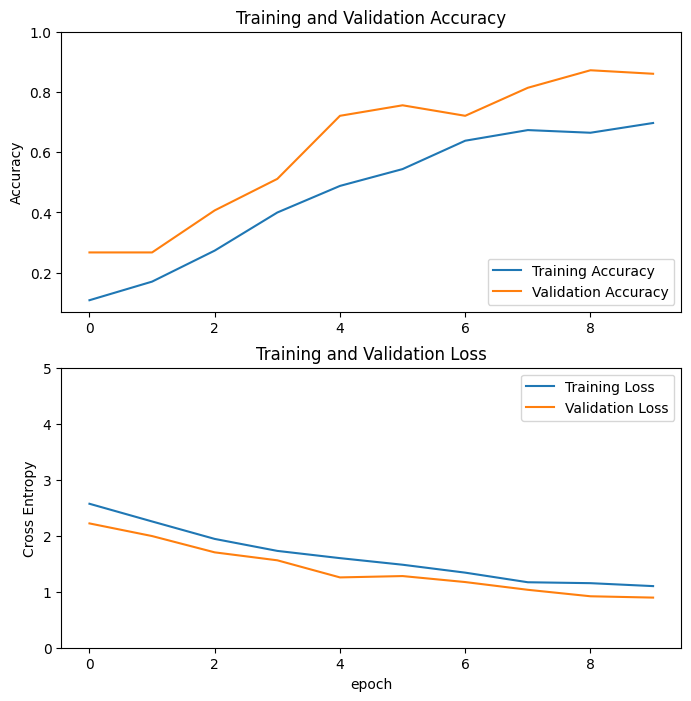

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
# 모델 미세 조정
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [40]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [41]:
len(model.trainable_variables)

56

In [42]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 10/20
34/34 [==============================] - 20s 294ms/step - loss: 0.6775 - accuracy: 0.8029 - val_loss: 0.4777 - val_accuracy: 0.8837
Epoch 11/20
34/34 [==============================] - 8s 208ms/step - loss: 0.3436 - accuracy: 0.9000 - val_loss: 0.2945 - val_accuracy: 0.9535
Epoch 12/20
34/34 [==============================] - 10s 270ms/step - loss: 0.3140 - accuracy: 0.9206 - val_loss: 0.1760 - val_accuracy: 0.9767
Epoch 13/20
34/34 [==============================] - 10s 268ms/step - loss: 0.2831 - accuracy: 0.9176 - val_loss: 0.1428 - val_accuracy: 0.9884
Epoch 14/20
34/34 [==============================] - 8s 233ms/step - loss: 0.1484 - accuracy: 0.9735 - val_loss: 0.0795 - val_accuracy: 0.9884
Epoch 15/20
34/34 [==============================] - 10s 271ms/step - loss: 0.1876 - accuracy: 0.9471 - val_loss: 0.1088 - val_accuracy: 0.9767
Epoch 16/20
34/34 [==============================] - 9s 262ms/step - loss: 0.1316 - accuracy: 0.9735 - val_loss: 0.0903 - val_accuracy: 0.

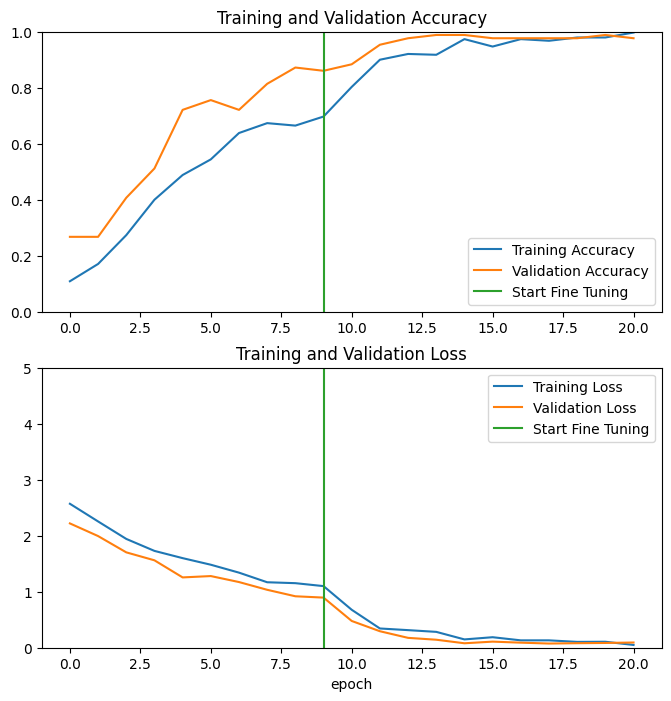

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
loss, accuracy = model.evaluate(train_dataset)
print('Train accuracy :', accuracy)

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

34/34 [==============================] - 5s 98ms/step - loss: 0.0692 - accuracy: 0.9824
Train accuracy : 0.9823529124259949
9/9 [==============================] - 4s 14ms/step - loss: 0.0852 - accuracy: 0.9767
Test accuracy : 0.9767441749572754


1/1 [==============================] - 1s 764ms/step


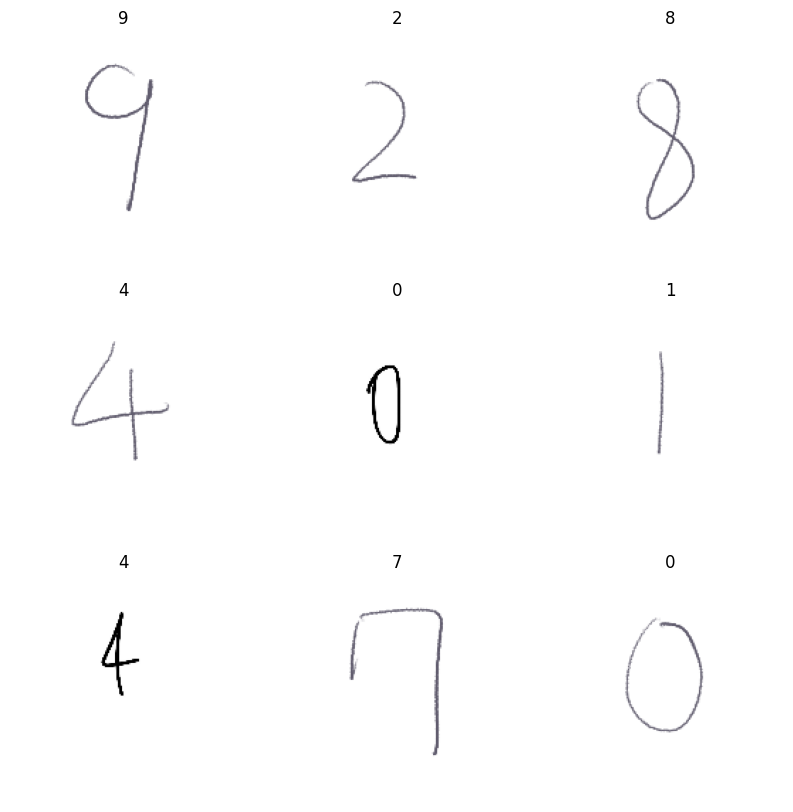

In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)

label = predictions.argmax(axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(label[i])
    plt.axis("off")